# Preliminary analysis of tRNA-seq: 2016-08-19-HG3W5AFXX 

Quick and dirty analysis from Daniel's tRNA experiment. This analysis is **INCOMPLETE**. Do not read too much into the results. 

- Quantification by standard alignment with `bowtie` to BY4741_pRS415 or BY4741_trnaNeoChrV10 genomes
- This alignment strategy does not account for complexities of tRNA reads, e.g. mature tRNA sequence vs. pre-tRNA, presence of introns
- Samples run on NextSeq

*Samples*
- **Sample 1: BY4741 + 128 kb neochromosome**
- **Sample 2: BY4741 + pRS415**
- Sample 3: triple-syn + 128 kb neochromosome
- Sample 4: triple-syn + pRS415

**Since I don't have genome sequence for triple-syn, I only analyze BY4741 derived samples**


# Read pre-processing
## Adapter trimming and merging reads

From Daniel's first tRNA-seq run: `2016-08-19-HG3W5AFXX`

Trying to process the reads before they are used downstream in ARMseq pipeline. According to ARMseq pipeline, reads (F and R for paired end reads) must be merged into a single file (using overlaps) before they are used in the pipeline. 

Here I show an example for **Sample 2**: *BY4741*

Also perform analysis for **Sample 1**: *BY4741_neo*

### SeqPrep

First option for removing adapters and merging reads ins SeqPrep. This is the software suggested by ARMseq README Doc. 

This program both trims adapter sequences and tries to merge the reads.

After talking with Daniel and check the fastq files, I determined that there are two adapters present in the reads:

F_ADAPT="AGATCGGAAGAGCACACGTCT"
R_ADAPT="GATCGTCGGACTGTAGAACTCTGAAC"

These are very common in both pair files (F_ADAPT in \*_1 files, R_ADAPT in \*_2 files).

```
HOME="/home/brooks/IESY/trna/results/2016-08-19-HG3W5AFXX"
DATA="/home/brooks/IESY/trna/data/2016-08-19-HG3W5AFXX"

F_ADAPT="AGATCGGAAGAGCACACGTCT"
R_ADAPT="GATCGTCGGACTGTAGAACTCTGAAC"


# SegPrep does not seem to work - unable to assemble reads
/g/steinmetz/brooks/git/SeqPrep/SeqPrep \
  -f $DATA/HG3W5AFXX_tRNANEBNext_16s005526-1-1_Schraivogel_lane1sample1_1_sequence.txt.gz \
  -r $DATA/HG3W5AFXX_tRNANEBNext_16s005526-1-1_Schraivogel_lane1sample1_1_sequence.txt.gz \
  -1 $DATA/BY4741_neo_1_trimmed.fastq.gz \
  -2 $DATA/BY4741_neo_2_trimmed.fastq.gz \
  -3 $DATA/BY4741_neo_1_discard.fastq.gz \
  -4 $DATA/BY4741_neo_2_discard.fastq.gz \
  -A $F_ADAPT \
  -B $R_ADAPT \
  -E $DATA/BY4741_neo_alignments.fastq.gz \
  -s $DATA/BY4741_neo_merged.fastq.gz
```

SeqPrep does not seem to work. Unable to merge many reads (only 16 merged in the end)

```
Pairs Processed:        15207063
Pairs Merged:   16
Pairs With Adapters:    6410003
Pairs Discarded:        6410003
CPU Time Used (Minutes):        36.056833
```

### PEAR

Another option I found is PEAR. This program also merges paired-end reads.

```
S2_1="$DATA/HG3W5AFXX_tRNANEBNext_16s005526-1-1_Schraivogel_lane1sample2_1_sequence.txt"
S2_2="$DATA/HG3W5AFXX_tRNANEBNext_16s005526-1-1_Schraivogel_lane1sample2_2_sequence.txt"

pear \
  -f $S2_1 \
  -r $S2_2 \
  -o $DATA/S2 \
  -j 20

```

**Results**
```
Assembled reads ...................: 10,198,525 / 16,653,054 (61.241%)
Discarded reads ...................: 0 / 16,653,054 (0.000%)
Not assembled reads ...............: 6,454,529 / 16,653,054 (38.759%)
```

Nearly **61%** of paired reads were merged (assembled) with this approach. These paired reads will be used in further analysis

# Alignment

Compare alignments of merged paired-end reads (merged by `PEAR`) above with alignment of unpaired reads. 

All alignments performed using `bowtie2`

### Alignment: merged reads
```
INDEX2="/g/steinmetz/project/IESY/genomes/BY4741_pRS415/index/bowtie/BY4741_pRS415"
# align merged data
bowtie2 -x $INDEX2 \
  --very-sensitive-local \
  -U $DATA/S2.assembled.fastq.gz \
  -p 20 \
  | samtools view -bS \
  | samtools sort -o ${HOME}/alignments/S2_merge.bam
samtools index ${HOME}/alignments/S2_merge.bam
```
**Results**
```
10198525 reads; of these:
  10198525 (100.00%) were unpaired; of these:
    14303 (0.14%) aligned 0 times
    1432530 (14.05%) aligned exactly 1 time
    8751692 (85.81%) aligned >1 times
99.86% overall alignment rate
```

### Alignment: paired reads
```
bowtie2 -x $INDEX2 \
  --very-sensitive-local \
  -1 $S2_1.gz \
  -2 $S2_2.gz \
  -p 20 \
  | samtools view -bS \
  | samtools sort -o ${HOME}/alignments/S2_pairs.bam
samtools index ${HOME}/alignments/S2_pairs.bam
```

**Results**

```
16653054 reads; of these:
  16653054 (100.00%) were paired; of these:
    3147882 (18.90%) aligned concordantly 0 times
    1673868 (10.05%) aligned concordantly exactly 1 time
    11831304 (71.05%) aligned concordantly >1 times
    ----
    3147882 pairs aligned concordantly 0 times; of these:
      205704 (6.53%) aligned discordantly 1 time
    ----
    2942178 pairs aligned 0 times concordantly or discordantly; of these:
      5884356 mates make up the pairs; of these:
        2565567 (43.60%) aligned 0 times
        38532 (0.65%) aligned exactly 1 time
        3280257 (55.75%) aligned >1 times
92.30% overall alignment rate
```

# Analysis

### Goals:
- How many rRNA reads compared to tRNA reads?
- First pass at differences in tRNA levels wrt tRNA neochromosome

In [2]:
# Rlibs
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(parallel);
options(mc.cores = 24);
library(stringr);
library(RColorBrewer);
library(GenomicRanges);
library(tidyr);
library(Rsamtools);
library(Biostrings);
library(seqinr);

In [3]:
# load annotations
f = "/g/steinmetz/brooks/yeast/annotations/SGD_features.rda"
if (!file.exists(f)) {
    annotations = read.delim("/g/steinmetz/brooks/yeast/annotations/SGD_features.txt", 
                             sep="\t", header = F, stringsAsFactors = F)
    colnames(annotations) = c("SGDID", "FEATURE_TYPE", "FEATURE_QUALIFIER",
                             "FEATURE_NAME", "GENE_NAME", "ALIAS",
                             "PARENT_FEATURE_NAME", "SECONDARY_SGDID",
                             "CHROMOSOME", "START", "STOP",
                             "STRAND", "GENETIC_POSITION","COORDINATE_VERSION",
                             "SEQUENCE_VERSIONS", "DESCRIPTION")
    annotations$CHROMOSOME = paste("chr", str_pad(annotations$CHROMOSOME, 2, pad = "0"), sep = "")
    annotations$STRAND = as.character(annotations$STRAND)
    annotations[which(annotations$STRAND == "W"),"STRAND"]= "+"
    annotations[which(annotations$STRAND == "C"),"STRAND"]= "-"
    annotations$START = as.numeric(annotations$START)
    annotations$END = as.numeric(annotations$END)
    save(annotations, file = f)
} else {
    load(f)
    # modify annotations so that start < end
    tochange = which(annotations$START > annotations$STOP)
    if (length(tochange) > 0) {
        tmp = annotations[tochange,]
        annotations[tochange,"START"] = tmp$STOP
        annotations[tochange,"STOP"] = tmp$START
    }
}

In [8]:
S1_merge="/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/alignments/S1_merge.bam"
S1_pairs="/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/alignments/S1_pairs.bam"
S2_merge="/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/alignments/S2_merge.bam"
S2_pairs="/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/alignments/S2_pairs.bam"

In [9]:
bamf = BamFileList(c(S1_merge,S1_pairs,S2_merge,S2_pairs))

In [10]:
# tRNA GRanges object
this = annotations %>% filter(FEATURE_TYPE == "tRNA_gene")
this = data.frame(chrom = this$CHROMOSOME, start = this$START, 
                    end = this$STOP, strand = this$STRAND, 
                    seqinfo = this$FEATURE_NAME)
trnas = as(this,"GRanges")

# rRNA GRanges object
this = annotations %>% filter(FEATURE_TYPE == "rRNA_gene")
this = data.frame(chrom = this$CHROMOSOME, start = this$START, 
                    end = this$STOP, strand = this$STRAND, 
                    seqinfo = this$FEATURE_NAME)
rrnas = as(this,"GRanges")

In [14]:
trna_counts = countBam(bamf, param=ScanBamParam(which = trnas))
trna_counts$type = "tRNA"

rrna_counts = countBam(bamf, param=ScanBamParam(which = rrnas))
rrna_counts$type = "rRNA"

counts = rbind(trna_counts, rrna_counts)

In [63]:
# make nice names
rename <- function(x) {
    if (class(x)=="factor") {
        xcopy = levels(x)[x]
    }
    xcopy[xcopy == "S1_merge.bam"] = "BY4741-neochr, Merged Reads"
    xcopy[xcopy == "S1_pairs.bam"] = "BY4741-neochr, Raw Paired Reads"
    xcopy[xcopy == "S2_merge.bam"] = "BY4741, Merged Reads"
    xcopy[xcopy == "S2_pairs.bam"] = "BY4741, Raw Paired Reads"
    xcopy = factor(xcopy, levels = c(
        "BY4741, Merged Reads", 
        "BY4741-neochr, Merged Reads",
        "BY4741, Raw Paired Reads",
        "BY4741-neochr, Raw Paired Reads"
    ))
    return(xcopy)
}
counts = counts %>% mutate(sample = rename(file))

# Figure 1

Warning message:
: Removed 124 rows containing non-finite values (stat_boxplot).

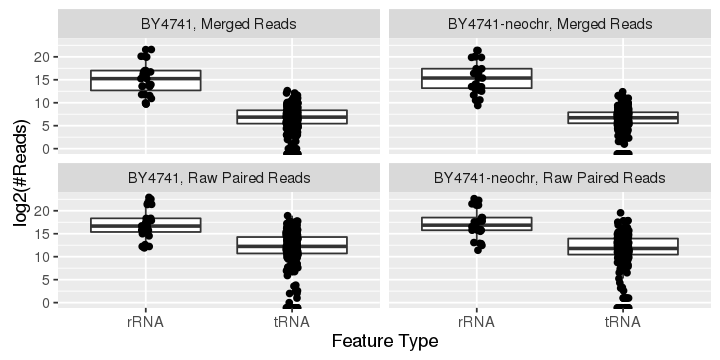

In [64]:
options(repr.plot.width = 6)
options(repr.plot.height = 3)
p <- ggplot(counts, aes(factor(type), log2(records)))

p + geom_boxplot(outlier.shape = NA) +
    facet_wrap(~ sample) + geom_jitter(width = 0.1) + 
    ylab("log2(#Reads)") +
    xlab("Feature Type")

# Table 1

Summary stats

In [71]:
counts %>% group_by(type, file, sample) %>% summarise(
    nreads.mean = mean(records), 
    nreads.median = median(records), 
    nread.sd = sd(records), 
    nreads.sum = sum(records))

,type,file,sample,nreads.mean,nreads.median,nread.sd,nreads.sum
1,rRNA,S1_merge.bam,"BY4741-neochr, Merged Reads",388467.4,42694,765998.2,10488621
2,rRNA,S1_pairs.bam,"BY4741-neochr, Raw Paired Reads",928443.4,119594,1717889,25067972
3,rRNA,S2_merge.bam,"BY4741, Merged Reads",424386.6,38904,872891.7,11458437
4,rRNA,S2_pairs.bam,"BY4741, Raw Paired Reads",1048444,104363,2040851,28307989
5,tRNA,S1_merge.bam,"BY4741-neochr, Merged Reads",234.3512,86,538.5242,70071
6,tRNA,S1_pairs.bam,"BY4741-neochr, Raw Paired Reads",15596.28,2914,53604.57,4663289
7,tRNA,S2_merge.bam,"BY4741, Merged Reads",297.9933,82,631.7588,89100
8,tRNA,S2_pairs.bam,"BY4741, Raw Paired Reads",19965.55,3829,45863.15,5969700


In [66]:
small_annotation = annotations %>% select(CHROMOSOME, START, STOP, FEATURE_NAME) %>% 
    mutate(id = paste(CHROMOSOME, START, STOP, sep="_")) %>% select(FEATURE_NAME, id)
counts_alt = counts %>% mutate(id = paste(space,start,end,sep="_"))
counts_alt = merge(x = counts_alt, y = small_annotation, by = "id") %>% filter(type == "tRNA") 
counts_alt$aa = sapply(counts_alt$FEATURE_NAME, function(x) {
    gsub("^t","",strsplit(x, split = "\\(")[[1]][1])
    })

# Figure 2

Warning message:
: Removed 126 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 102 rows containing non-finite values (stat_boxplot).

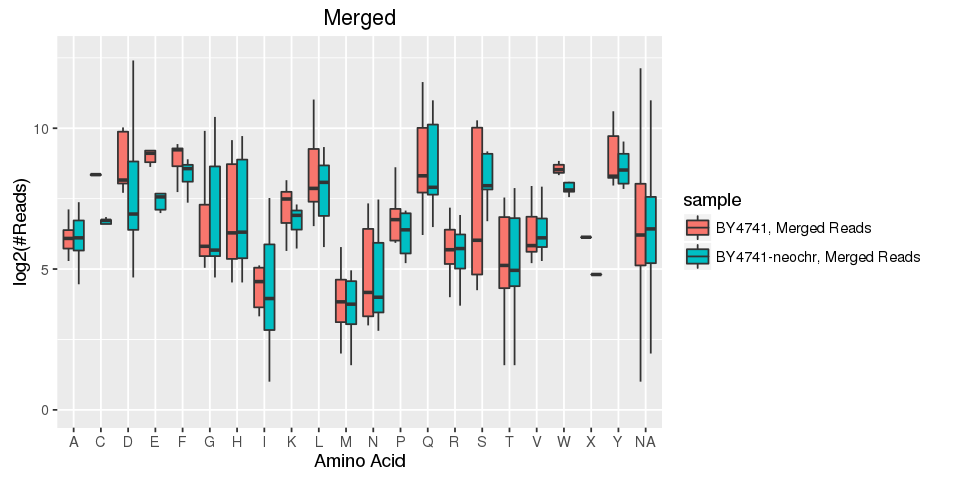

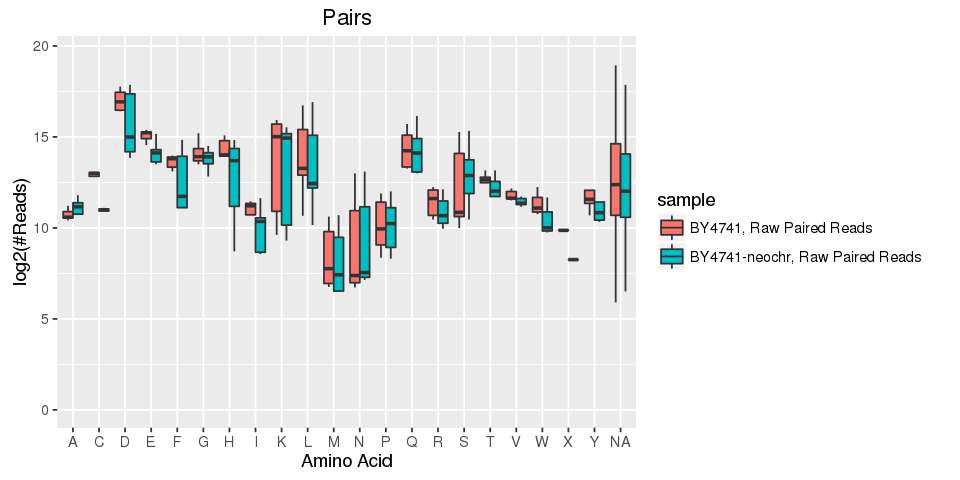

In [70]:
options(repr.plot.width=8, repr.plot.height=4)
thesecounts = counts_alt %>% filter(file %in% c("S1_merge.bam","S2_merge.bam"))
thesecounts2 = counts_alt %>% filter(file %in% c("S1_pairs.bam","S2_pairs.bam"))

p <- ggplot(thesecounts, aes(factor(aa), log2(records), fill = sample))

p + geom_boxplot(outlier.shape = NA) +
    ylab("log2(#Reads)") +
    xlab("Amino Acid") + ggtitle("Merged")

p2 <- ggplot(thesecounts2, aes(factor(aa), log2(records), fill = sample))

p2 + geom_boxplot(outlier.shape = NA) +
    ylab("log2(#Reads)") +
    xlab("Amino Acid") + ggtitle("Pairs")

Note: This figure contains entries that aren't actual amino acids. I know. This is a direct result of annotations from SGD. 

# Result 1

- **Figure 1**
- Many rRNA reads compared to tRNA reads. rRNA reads outnumber tRNA reads by as much as 1000-fold
- Aligning paired-end reads directly (rather than merging) results in high number of tRNA counts. This is likely because some of these reads are thrown out by merging process.
- **At a bulk level, tRNA levels do not appear to be different between strains w/w-o tRNA neochromosome** This may not be true for every tRNA and needs to be confirmed by more rigorous mapping procedure (ARMseq).

# Result 2

- **Figure 2**
- Most tRNAs (grouped by isotype) do not appear to be different. 
- There are a few expections, e.g. Glutamate (E), Tryptophan (W)
- Trends are *mostly* consistent across both mapping approaches

# Conclusions

Seemingly no bulk differences in tRNA levels. Possibly some differences in individual tRNA isotypes. Unclear. Needs more rigorous analysis with ARMseq protocol.